In the first chapter, we have completed the construction of the most basic fully connected network. In this chapter, we start the image classification task! As before, we also need to define the most basic functions, so let's get started.

In [28]:
import torch
import torch.nn as nn

In [25]:
import matplotlib.pyplot as plt
import numpy as np

When performing image classification tasks, we also define some necessary functions!

In [3]:
def softmax(x):
    a = torch.exp(x)
    return a / torch.sum(a, dim=-1, keepdim=True)

def cross_entropy(y_hat, y):
  index = list(range(len(y)))
  return -torch.log(y_hat[index, y])

def show_img(data, figsizes, num_imgs=6):
    _, axes = plt.subplots(2, 3, figsize=figsizes)
    for i in range(num_imgs):
      ax = axes[i//3, i%3]
      img, label = data[i]
      ax.imshow(img.squeeze(), cmap='gray')
      ax.set_title(f'Label:{label}')
      ax.axis('off')

$$ H(y, \hat{y}) = -\sum_{i} y_i \log(\hat{y}_i) $$
Beginners like us may have a question when facing the cross-entropy loss function. The formula is obviously $y_i \log(\hat{y}_i)$, but this process is not reflected in the code. Why?
We understand from the beginning. The reason is that $y_i$ is actually the result of one-hot encoding. We know that after one-hot encoding, except for the useful part, the rest becomes zero. As shown in the figure below, we created a tensor, which means that the indexes are 1 and 2. We performed one-hot encoding on it. We found that only the position value of the corresponding index is 1, and the rest are 0. Therefore, when $y_i$ is 0, multiplying by any number is 0.
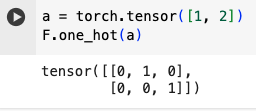
  
Then let's review the above code again. In fact, in the code, we index the value at the corresponding position and ignore the numbers at other positions. This is actually consistent with the above statement.

Regarding the indexing issue, I showed it in the following image.


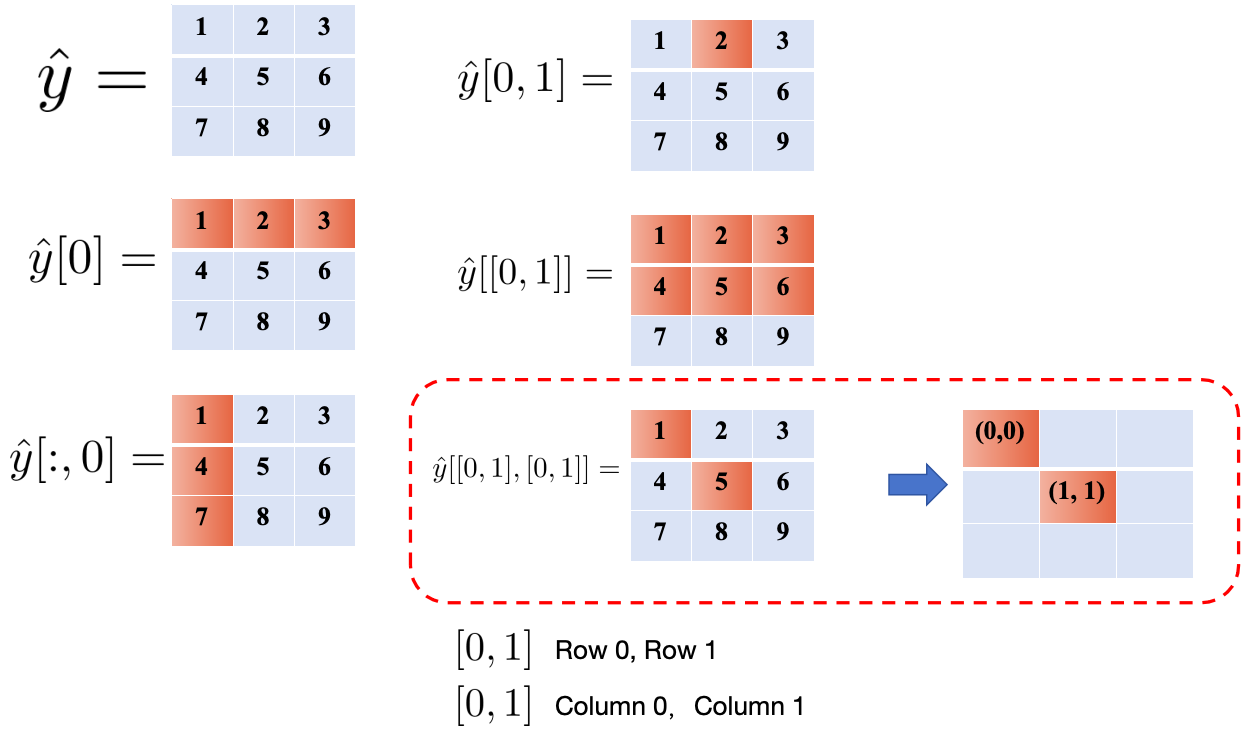

Starting from Chapter 2, the data set we use is the most classic **Mnist** data set. We can use pytorch to download this data set easily!

In [4]:
import torchvision
import torchvision.transforms as transforms

In [5]:
train_data = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
test_data = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 130905479.66it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 21413415.91it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 54040956.41it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4657830.99it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
len(train_data), len(test_data)

(60000, 10000)

In [7]:
# Image size
train_data[0][0].shape

torch.Size([1, 28, 28])

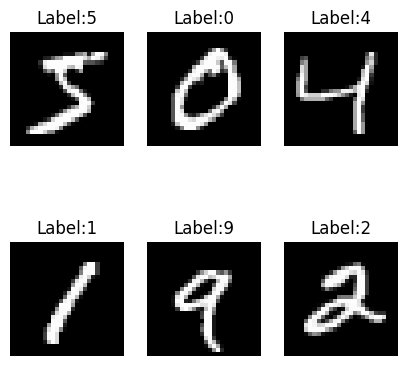

In [8]:
# data visualization
show_img(train_data, figsizes=(5, 5))

In [9]:
from random import shuffle

class ImageDataLoader:
    def __init__(self, datasets, batch_size, shuffle=False):
        self.datasets = datasets
        self.batch_size = batch_size
        self.indexes = list(range(len(self.datasets)))
        self.shuffle = shuffle
        self.num_imgs = len(datasets)

    def __iter__(self):
        self.start = 0
        if self.shuffle is True:
            shuffle(self.indexes)
        return self

    def __next__(self):
        start = self.start
        end = min(start+self.batch_size, len(self.datasets))
        if start >= end:
            raise StopIteration
        self.start += self.batch_size
        index = self.indexes[start:end]
        batch = [self.datasets[i] for i in index]
        data = torch.stack([img[0] for img in batch])
        label = torch.tensor([labels[1] for labels in batch])
        return data, label

    def __len__(self):
      return (len(self.datasets) + self.batch_size - 1) // self.batch_size


In [10]:
batch_size = 300
train_loader = ImageDataLoader(train_data, batch_size, shuffle=True)
test_loader = ImageDataLoader(test_data, batch_size, shuffle=True)

In [11]:
len(train_loader), len(test_loader)

(200, 34)

In [12]:
def fc(x, w, b):
  # the shape of x is (batch_size, 1, 28, 28)
  shape = x.shape
  x = x.reshape(shape[0], -1)
  y = torch.mm(x, w) + b
  return softmax(y)

In [13]:
def sgd(params, lr, batch_size):
  with torch.no_grad():
    # Optimize the previous code. The params entered here are a list.
    for param in params:
      param -= lr * param.grad / batch_size
      param.grad.zero_()

In [18]:
num_features = 784
num_hiddens = 10
# W = torch.normal(0, 0.01, size=(num_features, num_hiddens), requires_grad=True)
W = torch.randn((num_features, num_hiddens), requires_grad=True)
b = torch.zeros(num_hiddens, requires_grad=True)

In [19]:
num_epochs = 50
lr = 0.1

In [20]:
def validation(net, data_loader):
  correct = 0
  total = 0
  with torch.no_grad():
    for img, label in data_loader:
      y_hat = net(img, W, b)
      _, predicted = torch.max(y_hat, 1)
      correct += (predicted == label).sum()
      total += label.size(0)
  return  correct / total



In [22]:
loss_value = []
acc_value = []

When the weight parameter W obeys a smaller initial value

In [ ]:
for epoch in range(num_epochs):
  for i, (img, label) in enumerate(train_loader):
    l = cross_entropy(fc(img, W, b), label)
    l = l.mean()
    l.backward()
    sgd([W, b], lr, batch_size)
    if (i+1) % 100 == 0:
      print('Epoch [{}/{}], Step [{}/{}], Loss {:.4f}'.format(epoch+1, num_epochs,
                                                              i+1, len(train_loader),
                                                              l.item()))
  loss_value.append(l)
  accuracy = validation(fc, test_loader)
  acc_value.append(accuracy)
  print('Accuracy {:.2f}'.format(accuracy.item()))

Epoch [1/50], Step [100/200], Loss 2.2852
Epoch [1/50], Step [200/200], Loss 2.2448
Accuracy 0.30
Epoch [2/50], Step [100/200], Loss 2.2214
Epoch [2/50], Step [200/200], Loss 2.1838
Accuracy 0.49
Epoch [3/50], Step [100/200], Loss 2.1499
Epoch [3/50], Step [200/200], Loss 2.1079
Accuracy 0.61
Epoch [4/50], Step [100/200], Loss 2.0954
Epoch [4/50], Step [200/200], Loss 2.0556
Accuracy 0.68
Epoch [5/50], Step [100/200], Loss 2.0192
Epoch [5/50], Step [200/200], Loss 2.0040
Accuracy 0.70
Epoch [6/50], Step [100/200], Loss 1.9632
Epoch [6/50], Step [200/200], Loss 1.9309
Accuracy 0.72
Epoch [7/50], Step [100/200], Loss 1.8814
Epoch [7/50], Step [200/200], Loss 1.8755
Accuracy 0.73
Epoch [8/50], Step [100/200], Loss 1.8813
Epoch [8/50], Step [200/200], Loss 1.8675
Accuracy 0.74
Epoch [9/50], Step [100/200], Loss 1.8434
Epoch [9/50], Step [200/200], Loss 1.8189
Accuracy 0.75
Epoch [10/50], Step [100/200], Loss 1.7532
Epoch [10/50], Step [200/200], Loss 1.7501
Accuracy 0.76
Epoch [11/50], Ste

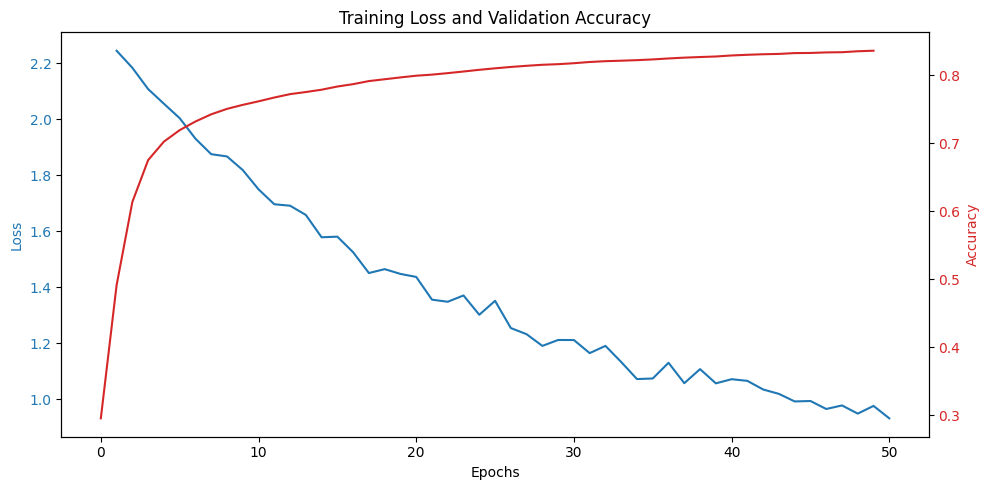

In [ ]:
import numpy as np
x = np.arange(1, 51, 1)

fig, ax1 = plt.subplots(figsize=(10, 5))
color = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(x, [loss.detach().numpy() for loss in loss_value], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(acc_value, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Training Loss and Validation Accuracy')
fig.tight_layout()
plt.show()


Training and testing situations when the weight parameter W obeys the standard Gaussian distribution

In [23]:
for epoch in range(num_epochs):
  for i, (img, label) in enumerate(train_loader):
    l = cross_entropy(fc(img, W, b), label)
    l = l.mean()
    l.backward()
    sgd([W, b], lr, batch_size)
    if (i+1) % 100 == 0:
      print('Epoch [{}/{}], Step [{}/{}], Loss {:.4f}'.format(epoch+1, num_epochs,
                                                              i+1, len(train_loader),
                                                              l.item()))
  loss_value.append(l)
  accuracy = validation(fc, test_loader)
  acc_value.append(accuracy)
  print('Accuracy {:.2f}'.format(accuracy.item()))

Epoch [1/50], Step [100/200], Loss 13.3457
Epoch [1/50], Step [200/200], Loss 13.0426
Accuracy 0.09
Epoch [2/50], Step [100/200], Loss 12.5253
Epoch [2/50], Step [200/200], Loss 13.3943
Accuracy 0.10
Epoch [3/50], Step [100/200], Loss 12.4585
Epoch [3/50], Step [200/200], Loss 13.0069
Accuracy 0.10
Epoch [4/50], Step [100/200], Loss 12.4777
Epoch [4/50], Step [200/200], Loss 12.8097
Accuracy 0.10
Epoch [5/50], Step [100/200], Loss 12.5544
Epoch [5/50], Step [200/200], Loss 12.9923
Accuracy 0.10
Epoch [6/50], Step [100/200], Loss 11.6434
Epoch [6/50], Step [200/200], Loss 12.5983
Accuracy 0.11
Epoch [7/50], Step [100/200], Loss 12.0874
Epoch [7/50], Step [200/200], Loss 12.2867
Accuracy 0.11
Epoch [8/50], Step [100/200], Loss 11.5739
Epoch [8/50], Step [200/200], Loss 11.5225
Accuracy 0.11
Epoch [9/50], Step [100/200], Loss 11.1730
Epoch [9/50], Step [200/200], Loss 10.6708
Accuracy 0.11
Epoch [10/50], Step [100/200], Loss 11.5533
Epoch [10/50], Step [200/200], Loss 10.9033
Accuracy 0.1

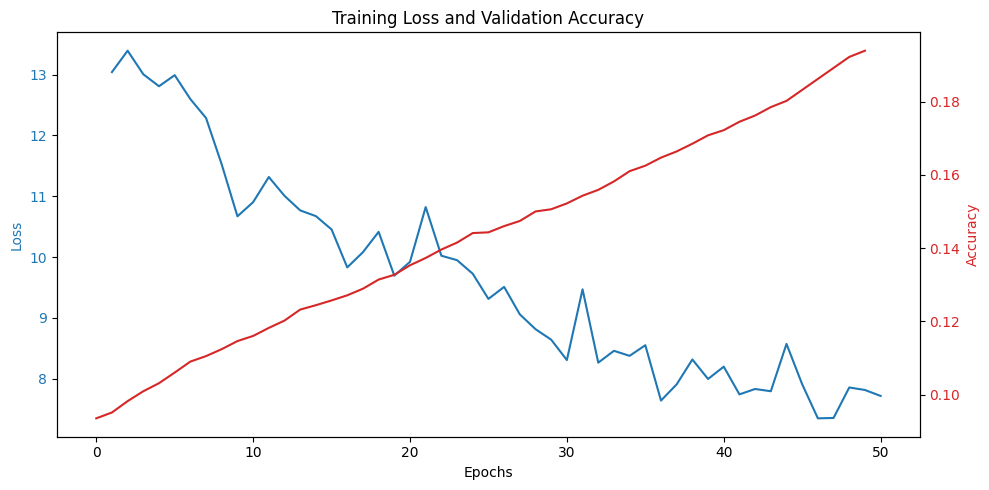

In [24]:
x = np.arange(1, 51, 1)
fig, ax1 = plt.subplots(figsize=(10, 5))
color = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(x, [loss.detach().numpy() for loss in loss_value], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(acc_value, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Training Loss and Validation Accuracy')
fig.tight_layout()
plt.show()


Why the initial value of the weight has such a great impact on the accuracy of the training results? This is because if the initial value of the weights is too large, the output of the neuron will quickly saturate when using activation functions such as Sigmoid or Tanh. In this case, the gradient of the activation function is almost zero, which causes the vanishing gradient problem, causing almost no gradient to be transferred during the backpropagation process, thus hindering the learning of the network. Let’s explain it through a few lines of code.

Text(0, 0.5, 'Y')

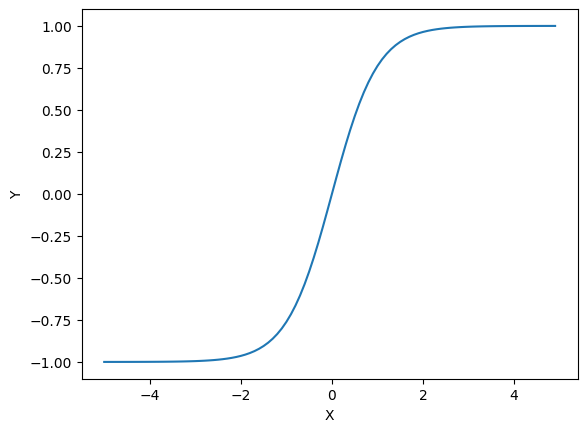

In [26]:
# We choose the tanh activation function to illustrate.
x = np.arange(-5, 5, 0.1)
y = np.tanh(x)
plt.plot(x, y)
plt.xlabel('X')
plt.ylabel('Y')

In [37]:
# Test
torch.manual_seed('0')
sample = torch.randn((100, 20))

In [49]:
class Net(nn.Module):
  def __init__(self, num_hiddens, num_layers, init_std):
    super().__init__()
    self.layers = nn.ModuleList([nn.Linear(num_hiddens, num_hiddens) for layer in range(num_layers)])
    for layer in self.layers:
      nn.init.normal_(layer.weight, mean=0, std=init_std)
  def forward(self, x):
    output = []
    for layer in self.layers:
      x = torch.tanh(layer(x))
      output.append(x)
    return output

In [50]:
# Small initial value
net1 = Net(20, 5, 0.01)
# Larger initial value
net2 = Net(20, 5, 1)

In [51]:
# output
y1 = net1(sample)
y2 = net2(sample)

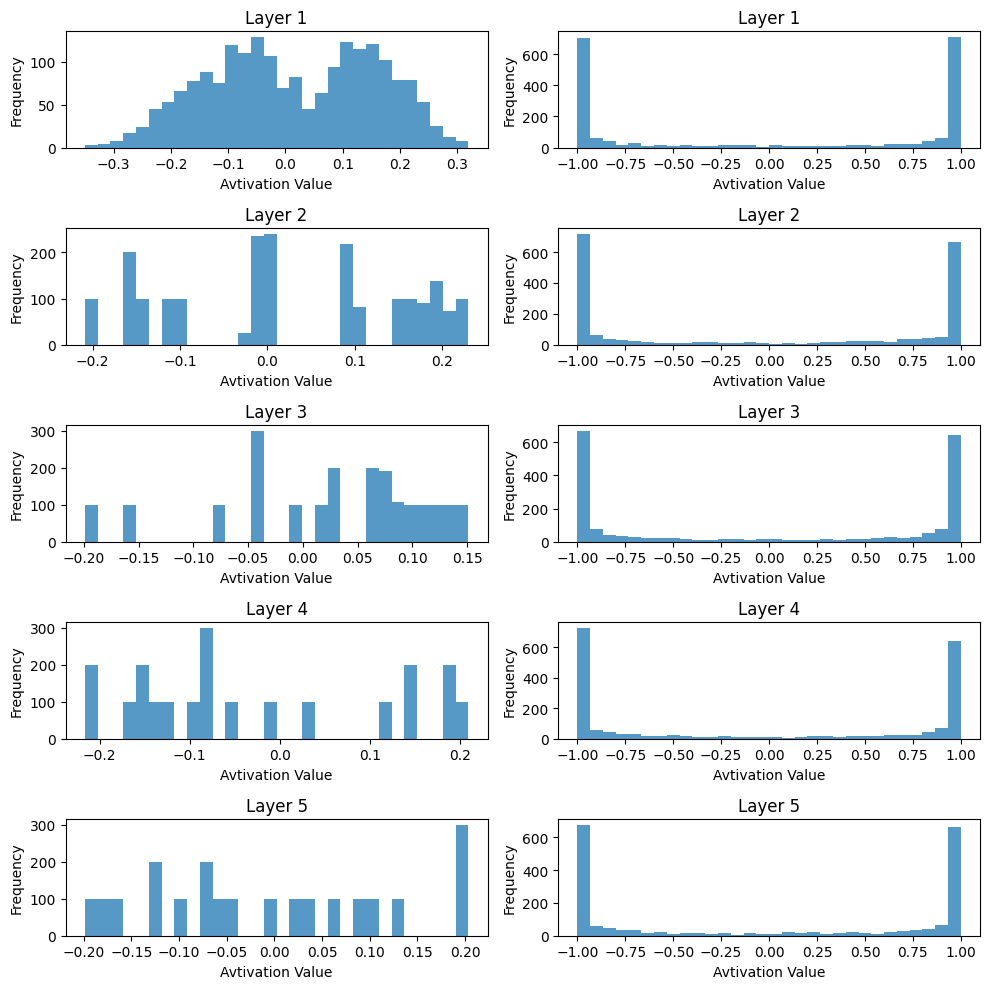

In [52]:
figs, axes = plt.subplots(5, 2, figsize=(10, 10))
for i, (small, large) in enumerate(zip(y1, y2)):
  axes[i, 0].hist(small.detach().numpy().flatten(), bins=30, alpha=0.75)
  axes[i, 0].set_title(f'Layer {i+1}')
  axes[i, 1].hist(large.detach().numpy().flatten(), bins=30, alpha=0.75)
  axes[i, 1].set_title(f'Layer {i+1}')

for ax in axes.flat:
  ax.set(xlabel='Avtivation Value', ylabel='Frequency')

figs.tight_layout()
plt.show()


Layers initialized with small weights have a more concentrated distribution of activation values, with most activation values close to 0, which helps prevent the activation function from saturating in early training.
Layers initialized with larger weights have a more dispersed distribution of activation values and more extreme values, which may cause the activation function (such as Sigmoid or Tanh) to enter the saturation region, causing the vanishing gradient problem.